In [1]:
!pip install -q kaggle

In [3]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.0 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!unzip /content/drive/MyDrive/temp/balanced_dataset.zip -d dataset/

In [9]:
model_path='/content/drive/MyDrive/UnetModels/BestHRPWUnet.h5'
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

model = load_model(model_path, custom_objects={'dice_loss': dice_loss})

**The 9 PLOTS**

Preprocessed image shape: (1, 512, 512, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


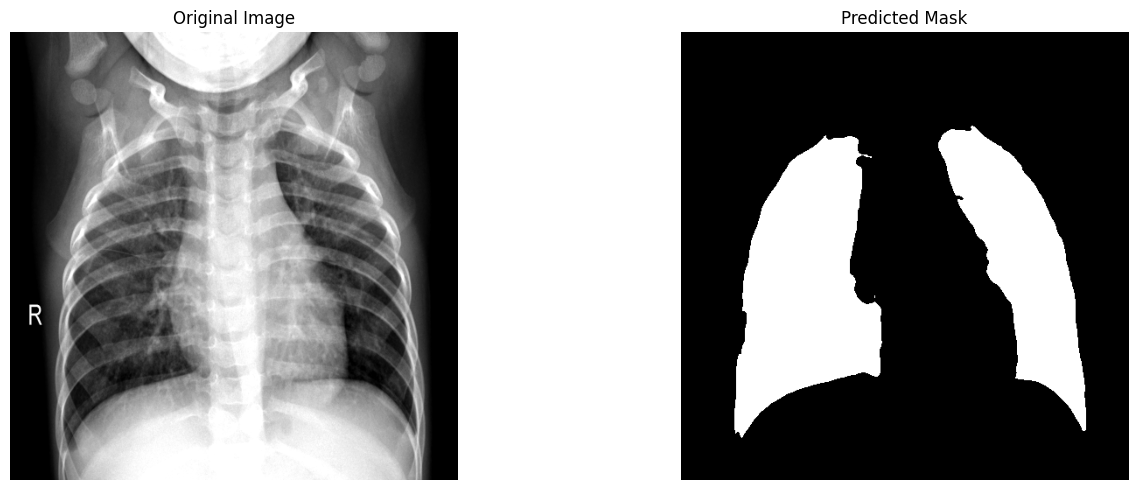

In [29]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(512,512)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


# Load and preprocess the image
image_path = "/content/dataset/Normal/Normal (1002).jpg"
original_image, preprocessed_image = load_and_preprocess_image(image_path)

image_path = "/content/dataset/Normal/Normal (103).jpg"
image_path = "/content/dataset/Normal/Normal (102).jpg"
image_path = "/content/dataset/Normal/Normal (1033).jpg"
image_path = "/content/dataset/Normal/Normal (1031).jpg"
image_path = "/content/dataset/Normal/Normal (107).jpg"
image_path = "/content/dataset/Normal/Normal (1077).jpg"
image_path = "/content/dataset/Normal/Normal (1082).jpg"
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print metrics
predicted_flat = predicted_mask_binary[0, :, :, 0].flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


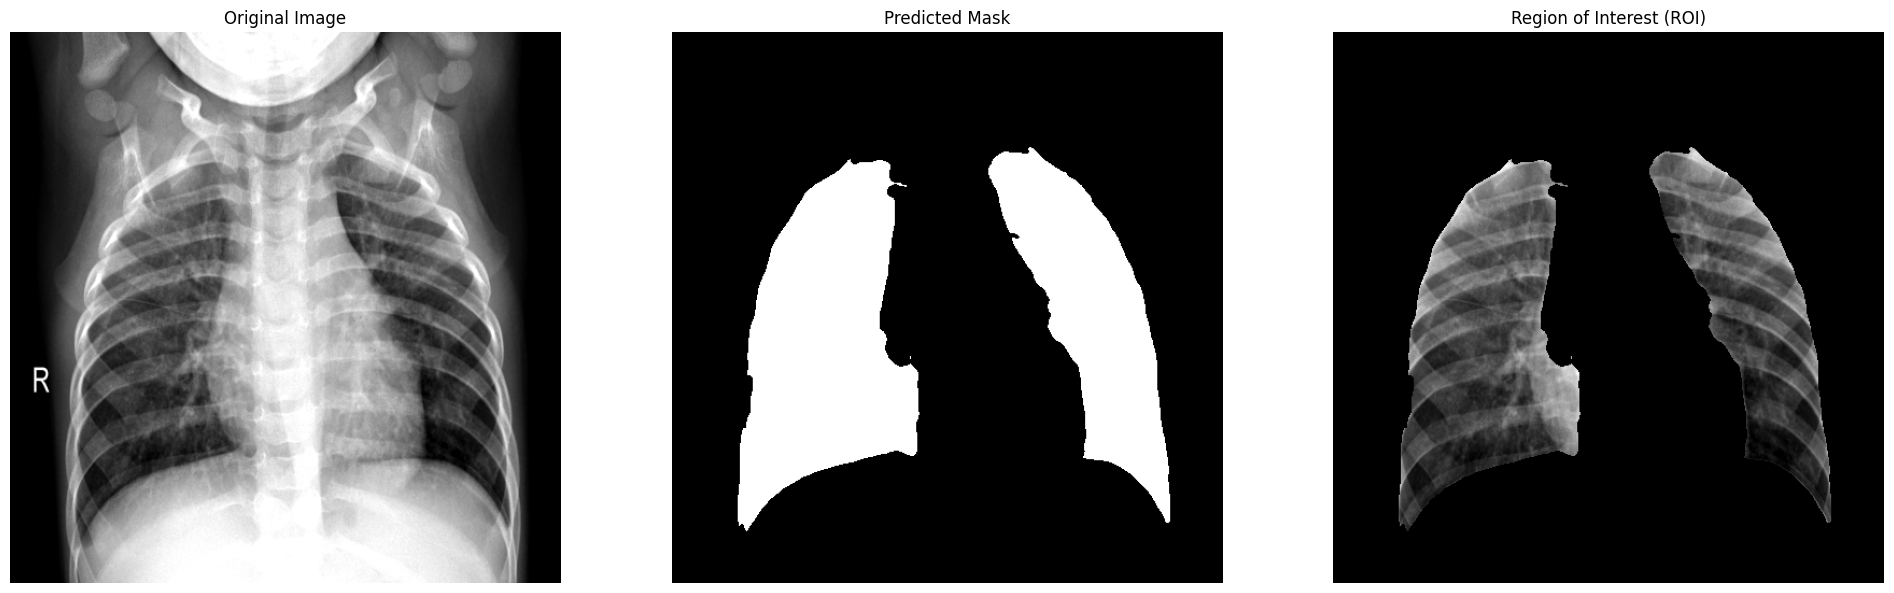

In [33]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(512,512)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image

# Load and preprocess the image
image_path = "/content/dataset/Normal/Normal (1082).jpg"  # Using one of your example paths
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Create ROI by applying mask to original image
roi = original_image.copy()
roi[predicted_mask_binary[0, :, :, 0] == 0] = 0  # Set non-mask areas to black

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# ROI
axes[2].imshow(roi, cmap='gray')
axes[2].set_title('Region of Interest (ROI)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Plot for Pneumonia Bacterial

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


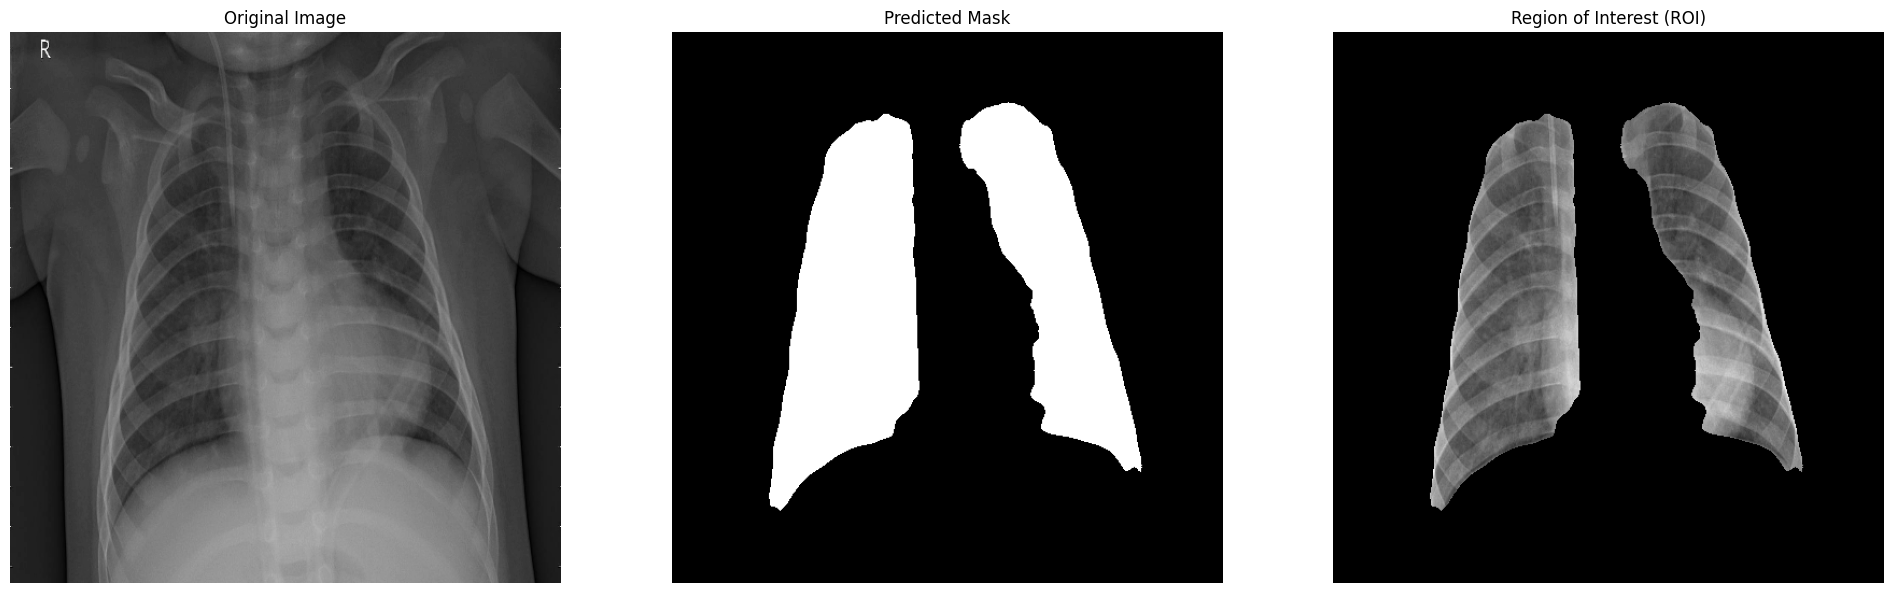

In [40]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(512,512)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image

image_path = "/content/dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1006).jpg"
image_path = "/content/dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1014).jpg"
image_path = "/content/dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1077).jpg"
image_path = "/content/dataset/Pneumonia-Bacterial/Pneumonia-Bacterial (1143).jpg"
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Create ROI by applying mask to original image
roi = original_image.copy()
roi[predicted_mask_binary[0, :, :, 0] == 0] = 0  # Set non-mask areas to black

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# ROI
axes[2].imshow(roi, cmap='gray')
axes[2].set_title('Region of Interest (ROI)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

PLots For Pneumonia Viral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


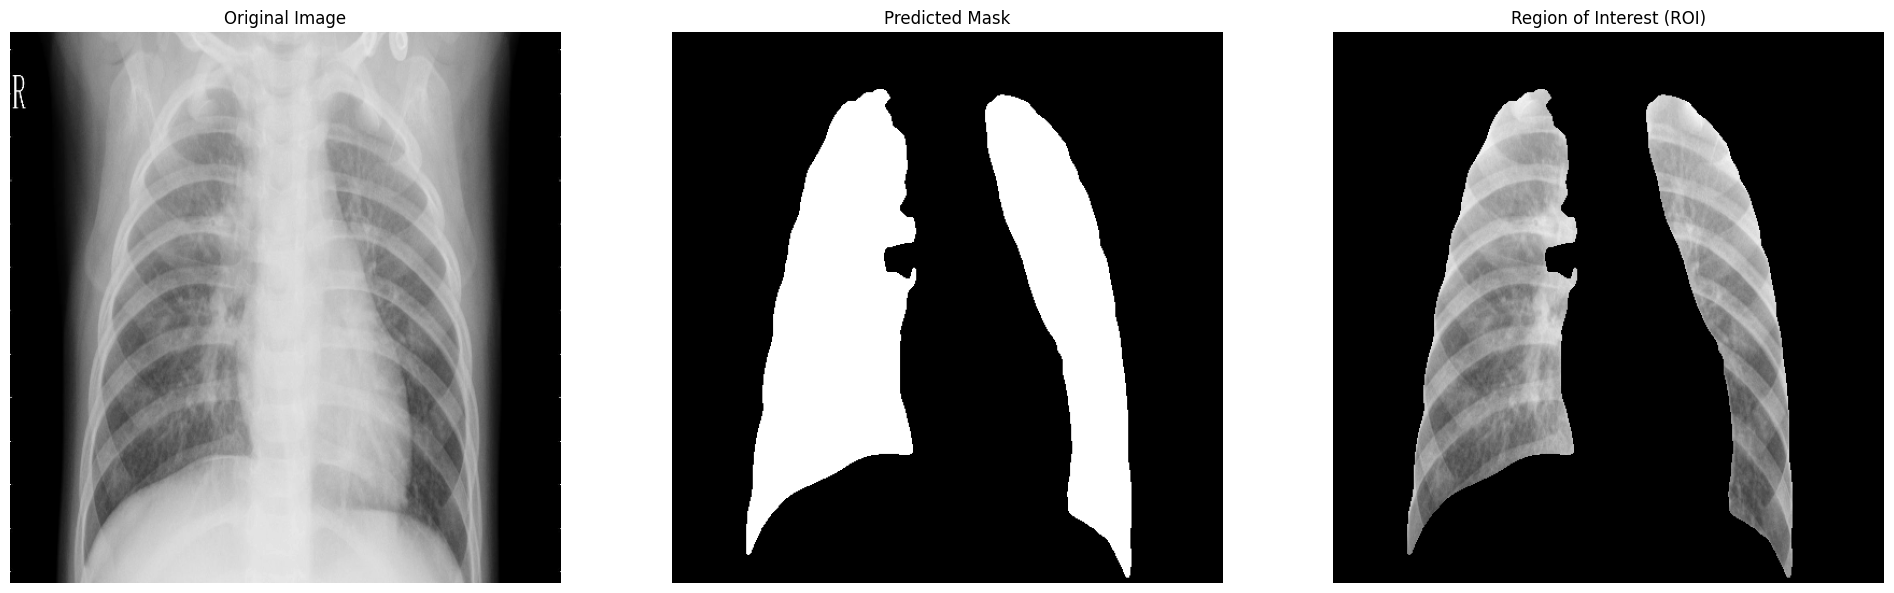

In [42]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
import tensorflow as tf

def load_and_preprocess_image(image_path, wavelet='db4', image_size=(512,512)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image

image_path = "/content/dataset/Pneumonia-Viral/Pneumonia-Viral (1006).jpg"
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Create ROI by applying mask to original image
roi = original_image.copy()
roi[predicted_mask_binary[0, :, :, 0] == 0] = 0  # Set non-mask areas to black

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted mask
axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

# ROI
axes[2].imshow(roi, cmap='gray')
axes[2].set_title('Region of Interest (ROI)')
axes[2].axis('off')

plt.tight_layout()
plt.show()